# FullClass-TrainCNN_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=528
img_width=528
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


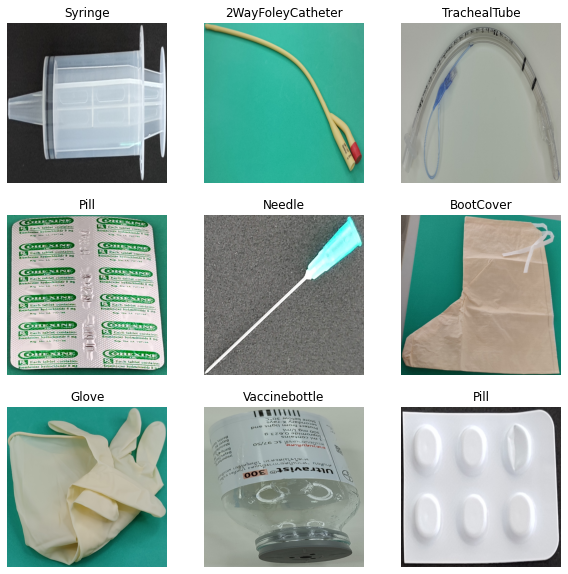

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  # ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 528, 528, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB6

efficientnetB0_model = keras.applications.EfficientNetB6(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

efficientnetB0_model_nooutput = efficientnetB0_model.layers[-3].output
custom_efficientnetB0_model = Model(inputs = efficientnetB0_model.input, outputs = efficientnetB0_model_nooutput)


174473216/174460376 [==============================] - 83s 0us/step


## Freez Extractor+

In [18]:
custom_efficientnetB0_model.trainable = False
for layer in custom_efficientnetB0_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_efficientnetB0_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 528, 528, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 528, 528, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 528, 528, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 529, 529, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [19]:
#tf.keras.utils.plot_model(custom_efficientnetB0_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_efficientnetB0_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2304)              40960143  
_________________________________________________________________
dense (Dense)                (None, 1024)              2360320   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                42025     
Total params: 43,362,488
Trainable params: 2,402,345
Non-trainable params: 40,960,143
_________________________________________________________________


In [22]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
#print(len(model.layers))
#tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/EfficientNetB6_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/'

In [25]:
EPOCHS = 2000
save_model_interval = 200
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 171s 3s/step - loss: 0.9329 - accuracy: 0.7586 - val_loss: 0.2298 - val_accuracy: 0.9185
Epoch 2/2000
49/49 [==============================] - 122s 2s/step - loss: 0.1816 - accuracy: 0.9454 - val_loss: 0.1218 - val_accuracy: 0.9690
Epoch 3/2000
49/49 [==============================] - 122s 2s/step - loss: 0.0941 - accuracy: 0.9784 - val_loss: 0.1134 - val_accuracy: 0.9599
Epoch 4/2000
49/49 [==============================] - 122s 2s/step - loss: 0.0643 - accuracy: 0.9816 - val_loss: 0.0884 - val_accuracy: 0.9715
Epoch 5/2000
49/49 [==============================] - 122s 2s/step - loss: 0.0462 - accuracy: 0.9887 - val_loss: 0.0592 - val_accuracy: 0.9845
Epoch 6/2000
49/49 [==============================] - 122s 2s/step - loss: 0.0300 - accuracy: 0.9939 - val_loss: 0.0559 - val_accuracy: 0.9780
Epoch 7/2000
49/49 [==============================] - 121s 2s/step - loss: 0.0262 - accuracy: 0.9932 - val_loss: 0.0705 - val_accuracy: 0.9741

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 201/2000
49/49 [==============================] - 121s 2s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0342 - val_accuracy: 0.9909
Epoch 202/2000
49/49 [==============================] - 121s 2s/step - loss: 9.5612e-04 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9897
Epoch 203/2000
49/49 [==============================] - 121s 2s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0340 - val_accuracy: 0.9897
Epoch 204/2000
49/49 [==============================] - 121s 2s/step - loss: 8.6537e-04 - accuracy: 1.0000 - val_loss: 0.0331 - val_accuracy: 0.9897
Epoch 205/2000
49/49 [==============================] - 121s 2s/step - loss: 7.9067e-04 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy: 0.9897
Epoch 206/2000
49/49 [==============================] - 122s 2s/step - loss: 8.0390e-04 - accuracy: 1.0000 - val_loss: 0.0331 - val_accuracy: 0.9884
Epoch 207/2000
49/49 [==============================] - 121s 2s/step - loss: 7.8571e-04 - accuracy: 1.0000 - val_l

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 401/2000
49/49 [==============================] - 121s 2s/step - loss: 3.5501e-04 - accuracy: 1.0000 - val_loss: 0.0297 - val_accuracy: 0.9922
Epoch 402/2000
49/49 [==============================] - 121s 2s/step - loss: 4.0067e-04 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 0.9922
Epoch 403/2000
49/49 [==============================] - 121s 2s/step - loss: 5.8905e-04 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 0.9922
Epoch 404/2000
49/49 [==============================] - 121s 2s/step - loss: 4.5580e-04 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 0.9897
Epoch 405/2000
49/49 [==============================] - 121s 2s/step - loss: 4.2235e-04 - accuracy: 1.0000 - val_loss: 0.0291 - val_accuracy: 0.9909
Epoch 406/2000
49/49 [==============================] - 121s 2s/step - loss: 3.5783e-04 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 0.9909
Epoch 407/2000
49/49 [==============================] - 121s 2s/step - loss: 3.1778e-04 - accuracy: 1.0000

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 601/2000
49/49 [==============================] - 121s 2s/step - loss: 1.8300e-04 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9922
Epoch 602/2000
49/49 [==============================] - 121s 2s/step - loss: 8.6765e-04 - accuracy: 0.9997 - val_loss: 0.0276 - val_accuracy: 0.9922
Epoch 603/2000
49/49 [==============================] - 121s 2s/step - loss: 2.1835e-04 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 0.9922
Epoch 604/2000
49/49 [==============================] - 121s 2s/step - loss: 2.0239e-04 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 0.9922
Epoch 605/2000
49/49 [==============================] - 121s 2s/step - loss: 2.5735e-04 - accuracy: 1.0000 - val_loss: 0.0270 - val_accuracy: 0.9909
Epoch 606/2000
49/49 [==============================] - 121s 2s/step - loss: 3.2009e-04 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9909
Epoch 607/2000
49/49 [==============================] - 121s 2s/step - loss: 2.4405e-04 - accuracy: 1.0000

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 801/2000
49/49 [==============================] - 121s 2s/step - loss: 1.3570e-04 - accuracy: 1.0000 - val_loss: 0.0286 - val_accuracy: 0.9909
Epoch 802/2000
49/49 [==============================] - 121s 2s/step - loss: 1.8122e-04 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 0.9909
Epoch 803/2000
49/49 [==============================] - 121s 2s/step - loss: 1.8395e-04 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.9922
Epoch 804/2000
49/49 [==============================] - 121s 2s/step - loss: 2.3936e-04 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9922
Epoch 805/2000
49/49 [==============================] - 121s 2s/step - loss: 1.4610e-04 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9922
Epoch 806/2000
49/49 [==============================] - 121s 2s/step - loss: 1.1132e-04 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.9922
Epoch 807/2000
49/49 [==============================] - 121s 2s/step - loss: 1.3057e-04 - accuracy: 1.0000

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1001/2000
49/49 [==============================] - 121s 2s/step - loss: 7.7826e-05 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 0.9922
Epoch 1002/2000
49/49 [==============================] - 121s 2s/step - loss: 1.6034e-04 - accuracy: 1.0000 - val_loss: 0.0291 - val_accuracy: 0.9909
Epoch 1003/2000
49/49 [==============================] - 121s 2s/step - loss: 1.5208e-04 - accuracy: 1.0000 - val_loss: 0.0294 - val_accuracy: 0.9922
Epoch 1004/2000
49/49 [==============================] - 121s 2s/step - loss: 9.3029e-05 - accuracy: 1.0000 - val_loss: 0.0291 - val_accuracy: 0.9909
Epoch 1005/2000
49/49 [==============================] - 121s 2s/step - loss: 1.1971e-04 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 0.9922
Epoch 1006/2000
49/49 [==============================] - 121s 2s/step - loss: 9.9357e-05 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 0.9909
Epoch 1007/2000
49/49 [==============================] - 121s 2s/step - loss: 1.0695e-04 - accuracy:

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1201/2000
49/49 [==============================] - 122s 2s/step - loss: 8.6208e-05 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 0.9922
Epoch 1202/2000
49/49 [==============================] - 122s 2s/step - loss: 8.0928e-05 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 0.9935
Epoch 1203/2000
49/49 [==============================] - 122s 2s/step - loss: 2.9127e-04 - accuracy: 1.0000 - val_loss: 0.0285 - val_accuracy: 0.9935
Epoch 1204/2000
49/49 [==============================] - 122s 2s/step - loss: 7.3199e-05 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 0.9935
Epoch 1205/2000
49/49 [==============================] - 122s 2s/step - loss: 7.5579e-05 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 0.9935
Epoch 1206/2000
49/49 [==============================] - 122s 2s/step - loss: 8.5322e-05 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 0.9935
Epoch 1207/2000
49/49 [==============================] - 122s 2s/step - loss: 6.5599e-05 - accuracy:

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1401/2000
49/49 [==============================] - 122s 2s/step - loss: 8.0468e-05 - accuracy: 1.0000 - val_loss: 0.0313 - val_accuracy: 0.9909
Epoch 1402/2000
49/49 [==============================] - 122s 2s/step - loss: 3.7520e-05 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 0.9909
Epoch 1403/2000
49/49 [==============================] - 122s 2s/step - loss: 6.5888e-05 - accuracy: 1.0000 - val_loss: 0.0313 - val_accuracy: 0.9909
Epoch 1404/2000
49/49 [==============================] - 122s 2s/step - loss: 5.3603e-05 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 0.9909
Epoch 1405/2000
49/49 [==============================] - 122s 2s/step - loss: 5.4637e-05 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 0.9909
Epoch 1406/2000
49/49 [==============================] - 122s 2s/step - loss: 5.9214e-05 - accuracy: 1.0000 - val_loss: 0.0317 - val_accuracy: 0.9909
Epoch 1407/2000
49/49 [==============================] - 122s 2s/step - loss: 4.5187e-05 - accuracy:

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1601/2000
49/49 [==============================] - 122s 2s/step - loss: 3.1203e-05 - accuracy: 1.0000 - val_loss: 0.0306 - val_accuracy: 0.9922
Epoch 1602/2000
49/49 [==============================] - 122s 2s/step - loss: 3.2715e-05 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 0.9922
Epoch 1603/2000
49/49 [==============================] - 122s 2s/step - loss: 5.3977e-05 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 0.9922
Epoch 1604/2000
49/49 [==============================] - 122s 2s/step - loss: 2.6590e-05 - accuracy: 1.0000 - val_loss: 0.0302 - val_accuracy: 0.9922
Epoch 1605/2000
49/49 [==============================] - 122s 2s/step - loss: 2.9308e-05 - accuracy: 1.0000 - val_loss: 0.0301 - val_accuracy: 0.9922
Epoch 1606/2000
49/49 [==============================] - 122s 2s/step - loss: 2.8345e-05 - accuracy: 1.0000 - val_loss: 0.0298 - val_accuracy: 0.9935
Epoch 1607/2000
49/49 [==============================] - 122s 2s/step - loss: 2.9095e-05 - accuracy:

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1801/2000
49/49 [==============================] - 121s 2s/step - loss: 2.4388e-05 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 0.9922
Epoch 1802/2000
49/49 [==============================] - 121s 2s/step - loss: 6.7089e-05 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9922
Epoch 1803/2000
49/49 [==============================] - 121s 2s/step - loss: 2.9943e-05 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9922
Epoch 1804/2000
49/49 [==============================] - 121s 2s/step - loss: 2.3700e-05 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9909
Epoch 1805/2000
49/49 [==============================] - 121s 2s/step - loss: 3.4850e-05 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 0.9909
Epoch 1806/2000
49/49 [==============================] - 121s 2s/step - loss: 2.4240e-05 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 0.9909
Epoch 1807/2000
49/49 [==============================] - 121s 2s/step - loss: 4.1344e-05 - accuracy:

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Training and Validation Accuracy')

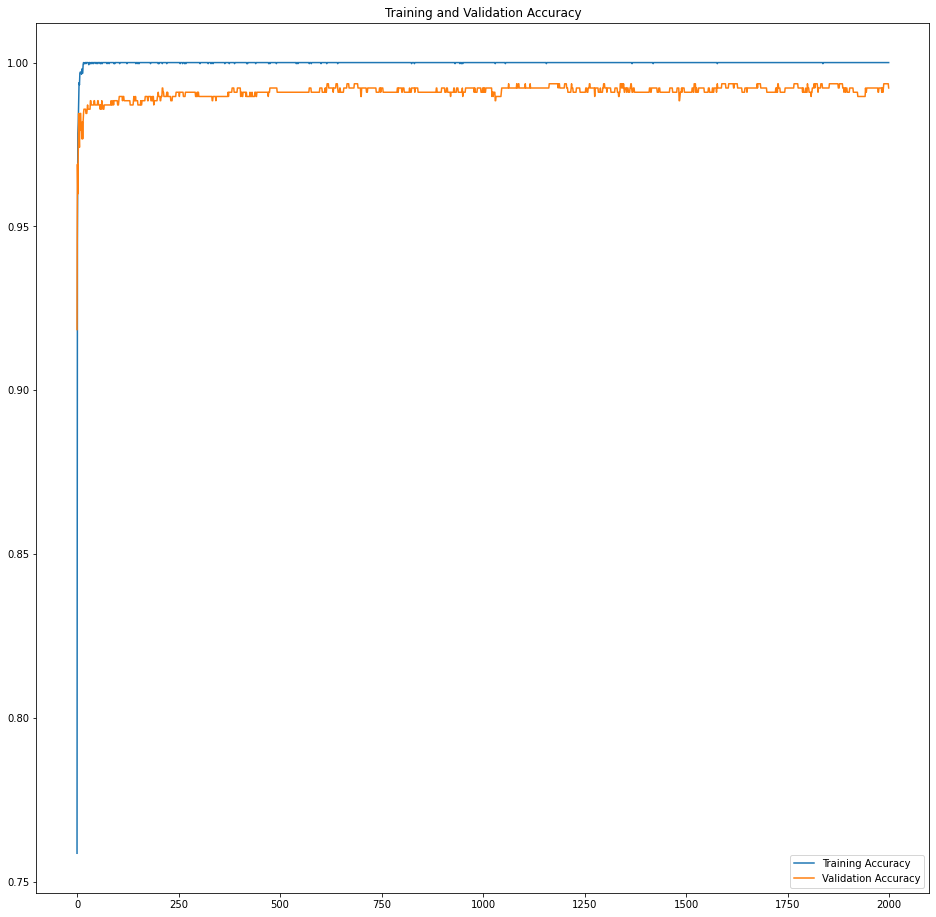

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


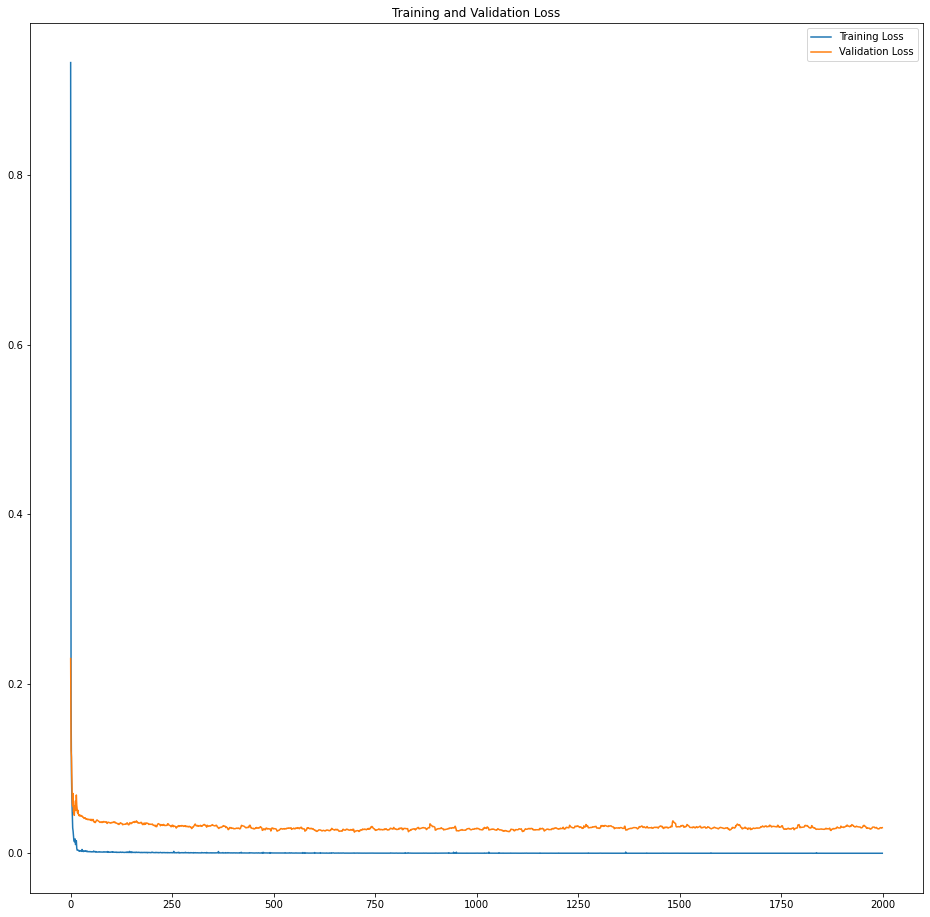

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 61s 2s/step - loss: 0.3480 - accuracy: 0.9348
test_indoor_ds_results:test loss, test acc: [0.3479897081851959, 0.9347826242446899]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 104s 2s/step - loss: 0.5550 - accuracy: 0.8742
test_outdoor_ds_results:test loss, test acc: [0.5550309419631958, 0.8742038011550903]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 72s 2s/step - loss: 1.5399 - accuracy: 0.7525
test_belt_ds_results:test loss, test acc: [1.5398839712142944, 0.7524932026863098]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/EfficientNetB6_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB6_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0400.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB6_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0600.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB6_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0800.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB6_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoCl

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 68s 2s/step - loss: 1.1651 - accuracy: 0.7452
Epoch200 
 test_indoor_acc=0.9325529336929321 
 test_outdoor_acc=0.8665605187416077 
 test_belt_acc=0.7452402710914612


35/35 [==============================] - 68s 2s/step - loss: 1.2249 - accuracy: 0.7461
Epoch400 
 test_indoor_acc=0.9319955110549927 
 test_outdoor_acc=0.8707006573677063 
 test_belt_acc=0.7461468577384949


35/35 [==============================] - 68s 2s/step - loss: 1.2739 - accuracy: 0.7484
Epoch600 
 test_indoor_acc=0.9331103563308716 
 test_outdoor_acc=0.868789792060852 
 test_belt_acc=0.7484134435653687


35/35 [==============================] - 68s 2s/step - loss: 1.3432 - accuracy: 0.7484
Epoch800 
 test_indoor_acc=0.9319955110549927 
 test_outdoor_acc=0.8713375926017761 
 test_belt_acc=0.7484134435653687


35/35 [==============================] - 68s 2s/step - loss: 1.3597 - accuracy: 0.7516
Epoch1000 
 test_indoor_acc=0.933667778968811 
 test_outdoor_acc=0.8729299306869507 
 test_belt_acc=0.7515865564346313


35/35 [==============================] - 68s 2s/step - loss: 1.3904 - accuracy: 0.7502
Epoch1200 
 test_indoor_acc=0.933667778968811 
 test_outdoor_acc=0.8726114630699158 
 test_belt_acc=0.7502266764640808


35/35 [==============================] - 68s 2s/step - loss: 1.4352 - accuracy: 0.7548
Epoch1400 
 test_indoor_acc=0.9347826242446899 
 test_outdoor_acc=0.8738853335380554 
 test_belt_acc=0.7547597289085388


35/35 [==============================] - 68s 2s/step - loss: 1.4697 - accuracy: 0.7493
Epoch1600 
 test_indoor_acc=0.9358974099159241 
 test_outdoor_acc=0.8777070045471191 
 test_belt_acc=0.7493200302124023


35/35 [==============================] - 68s 2s/step - loss: 1.5043 - accuracy: 0.7525
Epoch1800 
 test_indoor_acc=0.933667778968811 
 test_outdoor_acc=0.8748407363891602 
 test_belt_acc=0.7524932026863098


35/35 [==============================] - 68s 2s/step - loss: 1.5399 - accuracy: 0.7525
Epoch2000 
 test_indoor_acc=0.9347826242446899 
 test_outdoor_acc=0.8742038011550903 
 test_belt_acc=0.7524932026863098


In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(200, 2200, 200)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

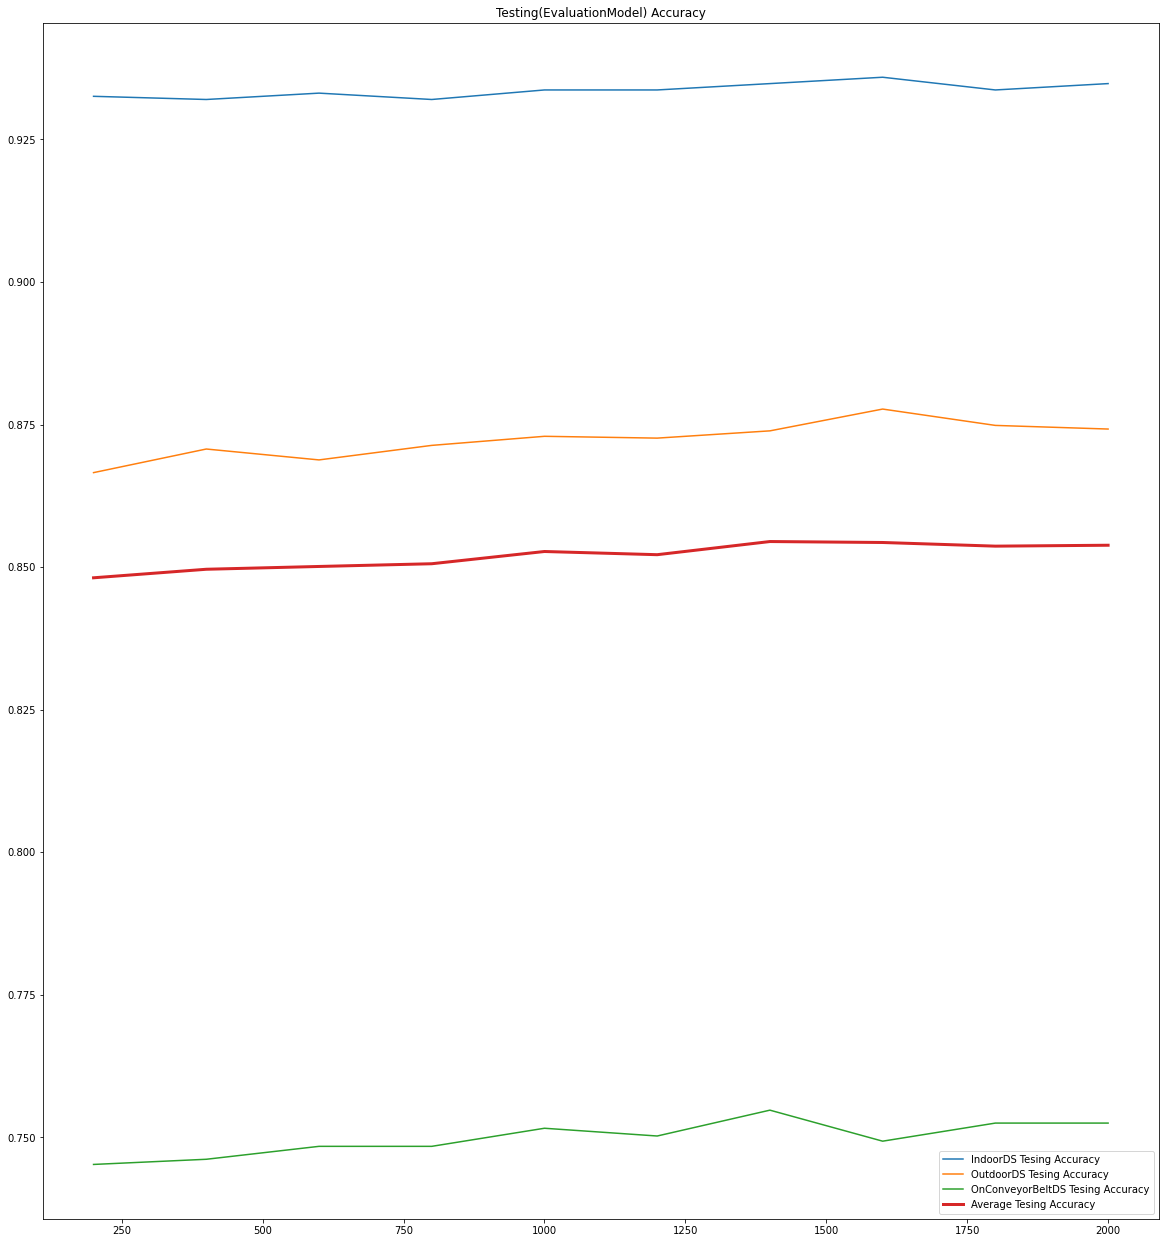

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.8544758955637614
max index -> 6
The [Epoch] of max acc -> 1400


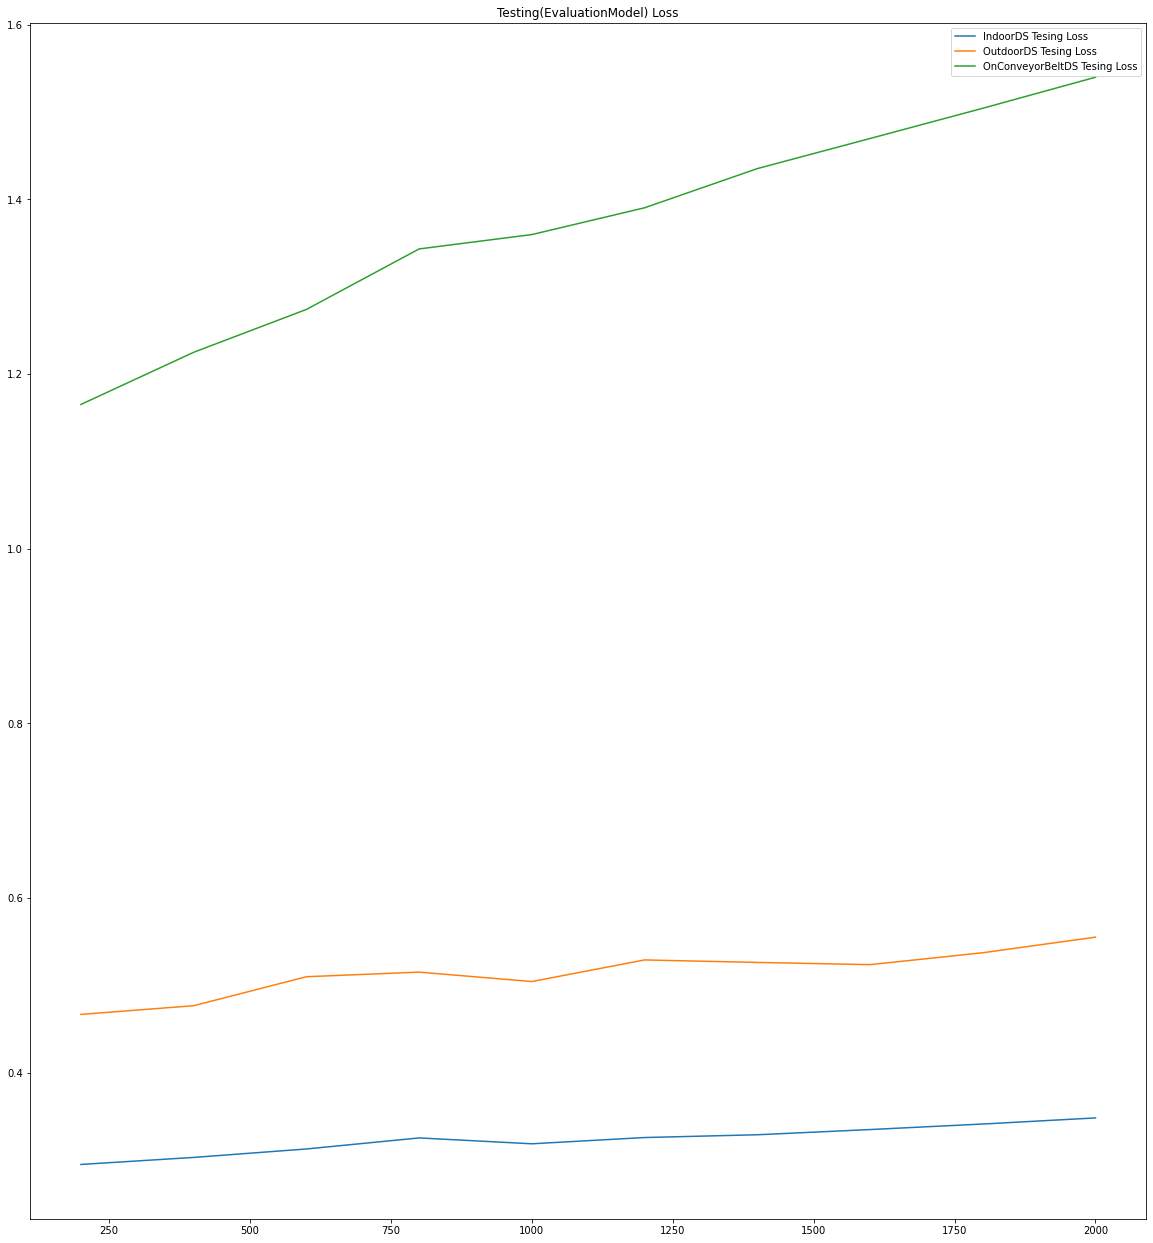

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.9325529336929321,
 0.9319955110549927,
 0.9331103563308716,
 0.9319955110549927,
 0.933667778968811,
 0.933667778968811,
 0.9347826242446899,
 0.9358974099159241,
 0.933667778968811,
 0.9347826242446899]

In [38]:
test_outdoor_acc

[0.8665605187416077,
 0.8707006573677063,
 0.868789792060852,
 0.8713375926017761,
 0.8729299306869507,
 0.8726114630699158,
 0.8738853335380554,
 0.8777070045471191,
 0.8748407363891602,
 0.8742038011550903]

In [39]:
test_belt_acc

[0.7452402710914612,
 0.7461468577384949,
 0.7484134435653687,
 0.7484134435653687,
 0.7515865564346313,
 0.7502266764640808,
 0.7547597289085388,
 0.7493200302124023,
 0.7524932026863098,
 0.7524932026863098]

In [40]:
test_indoor_loss

[0.2947179079055786,
 0.30275487899780273,
 0.3124302327632904,
 0.32507824897766113,
 0.3183651566505432,
 0.3255276083946228,
 0.3287155032157898,
 0.33467885851860046,
 0.34100693464279175,
 0.3479897081851959]

In [41]:
test_outdoor_loss

[0.4665471017360687,
 0.47650963068008423,
 0.5096961259841919,
 0.5149816870689392,
 0.504186749458313,
 0.5289248824119568,
 0.5260859727859497,
 0.5235458016395569,
 0.5371605157852173,
 0.5550309419631958]

In [42]:
test_belt_loss

[1.1651402711868286,
 1.2248669862747192,
 1.2739406824111938,
 1.3432410955429077,
 1.3596874475479126,
 1.3903707265853882,
 1.4352359771728516,
 1.4697229862213135,
 1.5043461322784424,
 1.5398839712142944]

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.efficientnet import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1600.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=528
img_width=528
batch_size=2

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  #ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
### VRAM not enough -> we split into N set
del x_test_indoor,x_test_outdoor,x_test_belt
N = 300
x_all_sets = np.array_split(x_all, N)
del x_all
y_all_sets_predicted = []
for x in x_all_sets:
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=2))
y_all_predicted = np.concatenate(y_all_sets_predicted)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=6088
FP=1052
acc=0.8526610644257703
all check = 7140


### acc

In [4]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 77.58620689655173%
2WayConnectorforFoley acc = 87.07482993197279%
2WayFoleyCatheter acc = 79.8507462686567%
3WayConnectorforFoley acc = 97.43589743589743%
3Waystopcock acc = 100.0%
AlcoholBottle acc = 87.5%
AlcoholPad acc = 56.34920634920635%
BootCover acc = 67.46987951807229%
CottonBall acc = 100.0%
CottonSwap acc = 89.5104895104895%
Dilator acc = 78.63247863247864%
DisposableInfusionSet acc = 92.92035398230088%
ExtensionTube acc = 62.601626016260155%
FaceShield acc = 78.39506172839506%
FrontLoadSyringe acc = 69.02654867256636%
GauzePad acc = 67.04545454545455%
Glove acc = 80.05952380952381%
GuideWire acc = 59.82142857142857%
LiquidBottle acc = 93.51145038167938%
Mask acc = 98.96103896103897%
NGTube acc = 74.83870967741936%
NasalCannula acc = 56.63716814159292%
Needle acc = 94.64285714285714%
OxygenMask acc = 96.99248120300751%
PPESuit acc = 83.87096774193549%
PharmaceuticalProduct acc = 75.70093457943925%
Pill acc = 96.35854341736695%
PillBottle acc = 95.3

In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 90,   0,   0, ...,   0,   0,   0],
       [  0, 128,   0, ...,   0,   0,   0],
       [  0,   0, 107, ...,   0,   0,  15],
       ...,
       [  0,   0,   0, ..., 117,   0,   0],
       [  0,   0,   0, ...,   0, 197,   0],
       [  0,   0,   0, ...,   0,   0,  98]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[77.5862069 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 87.07482993,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 79.85074627, ...,  0.        ,
         0.        , 11.19402985],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 97.5       ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        92.48826291,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 85.96491228]])

<AxesSubplot:>

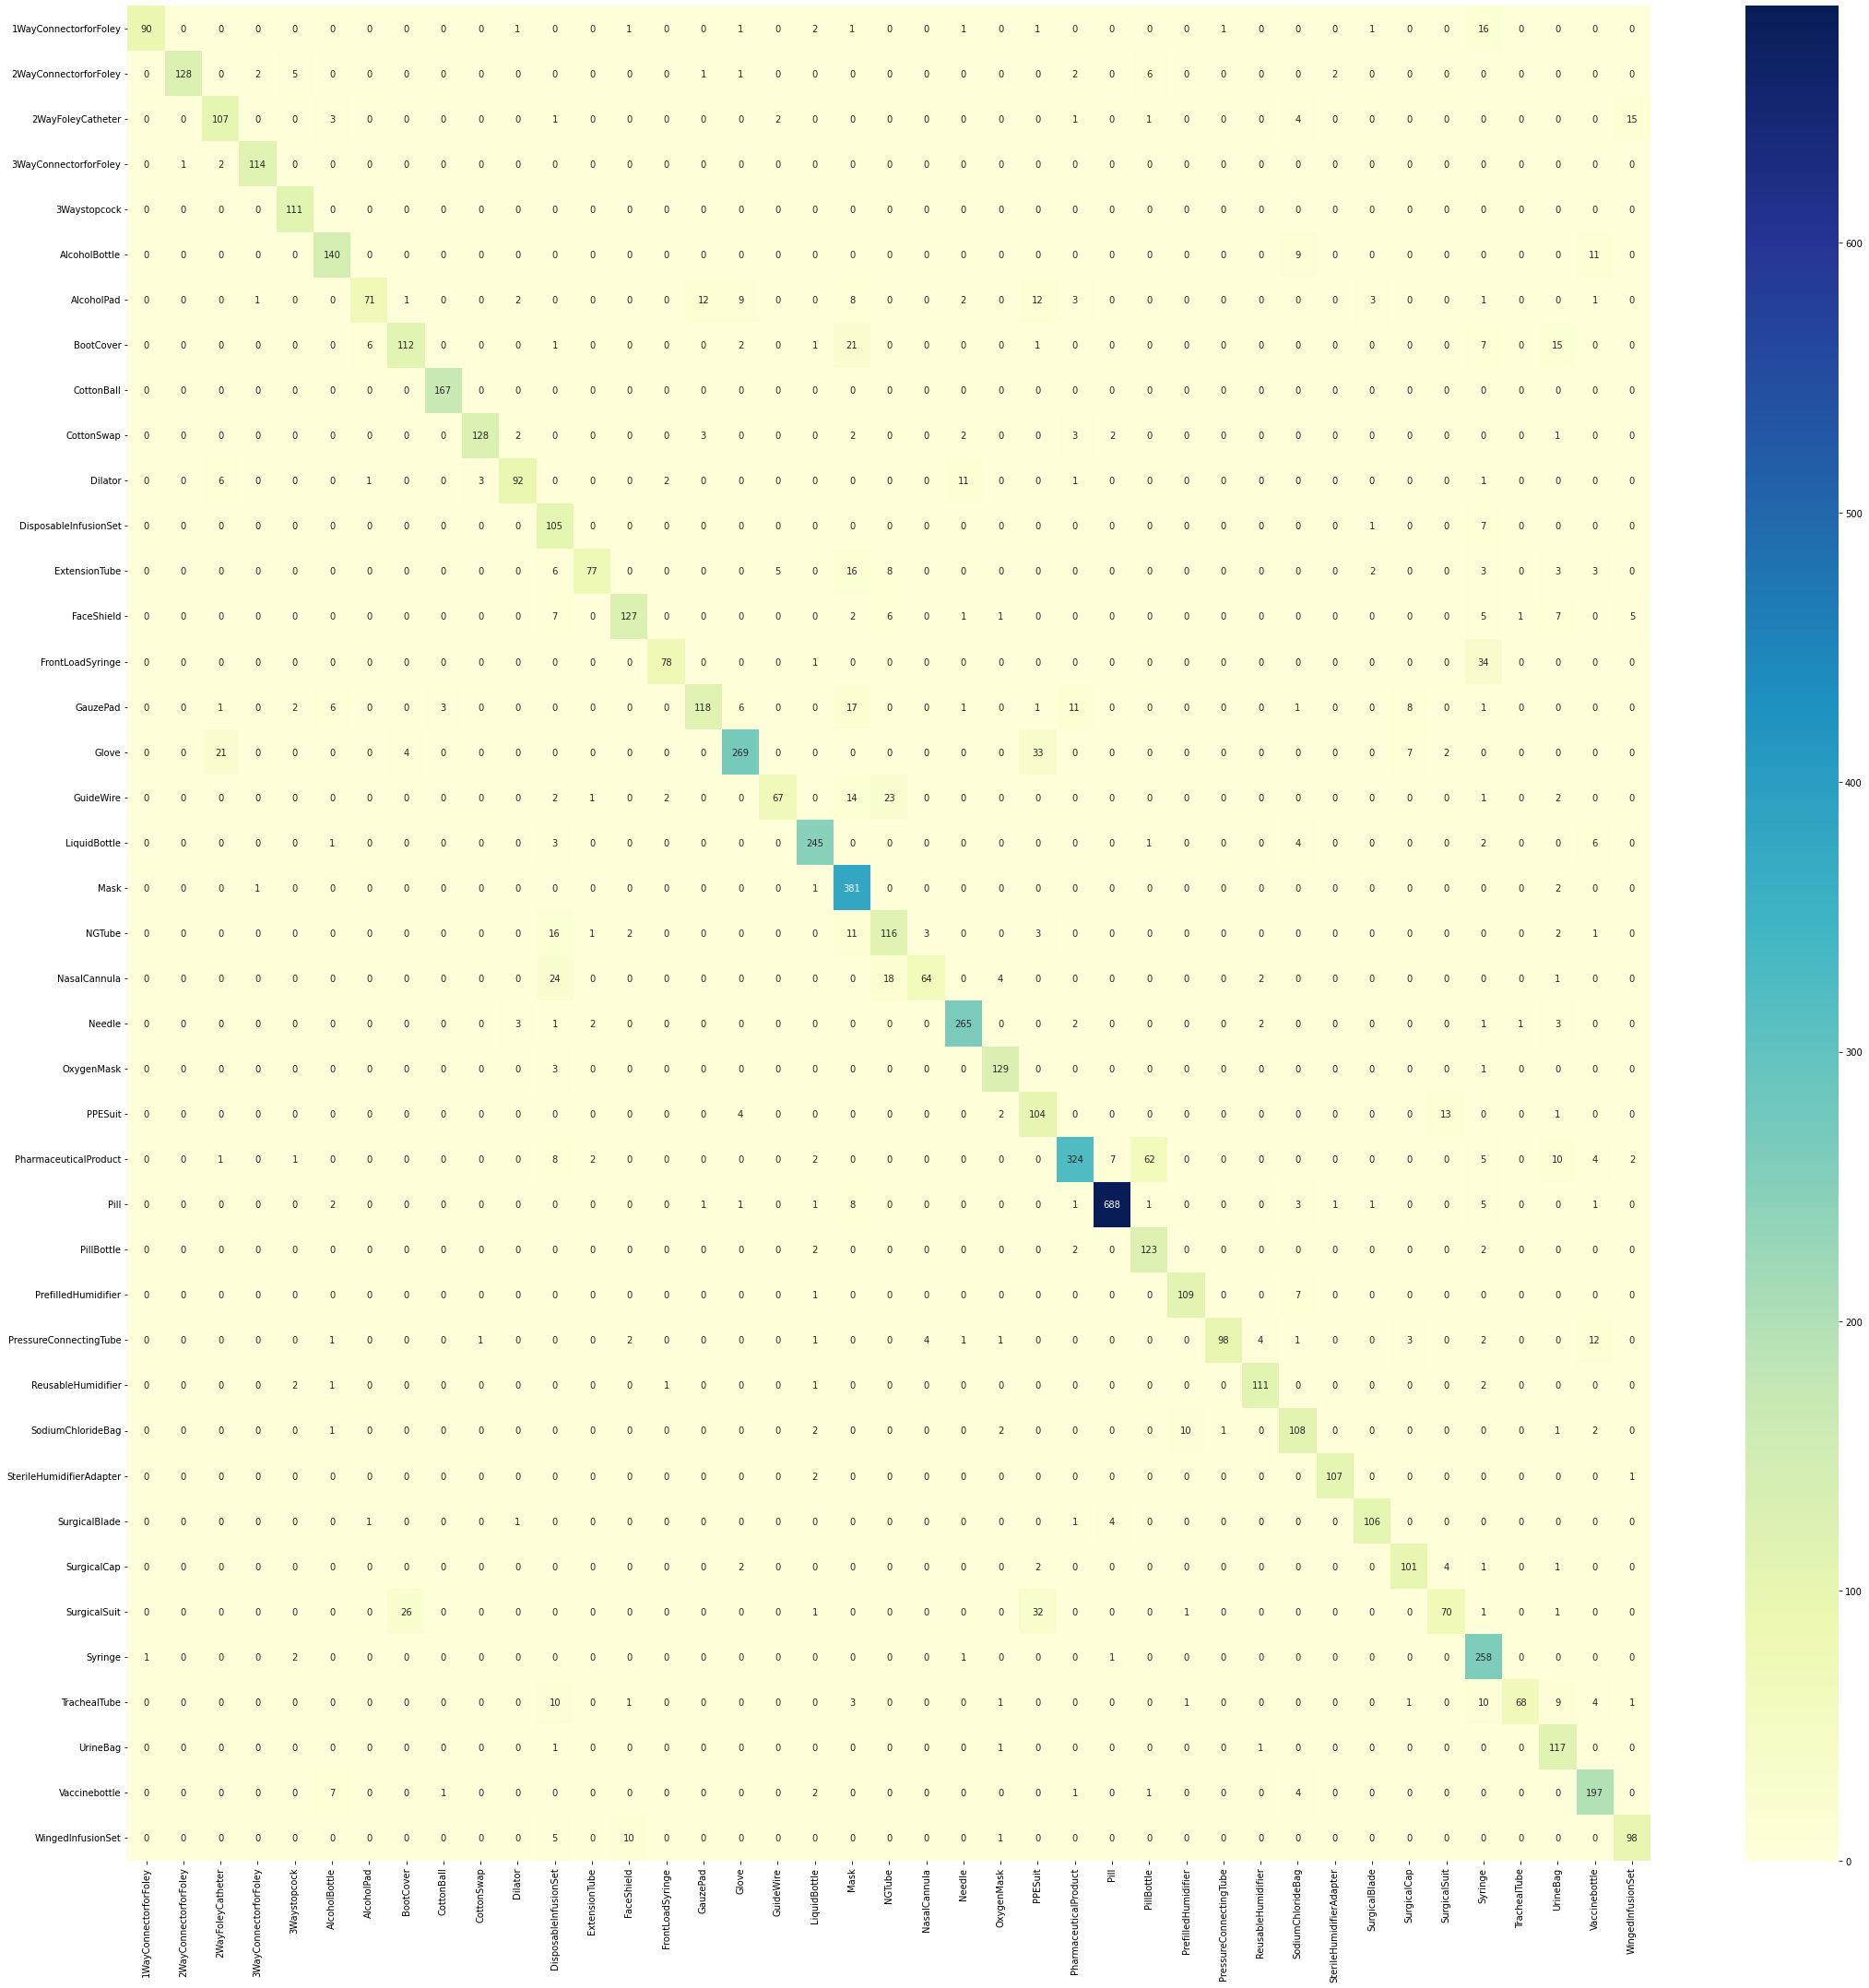

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

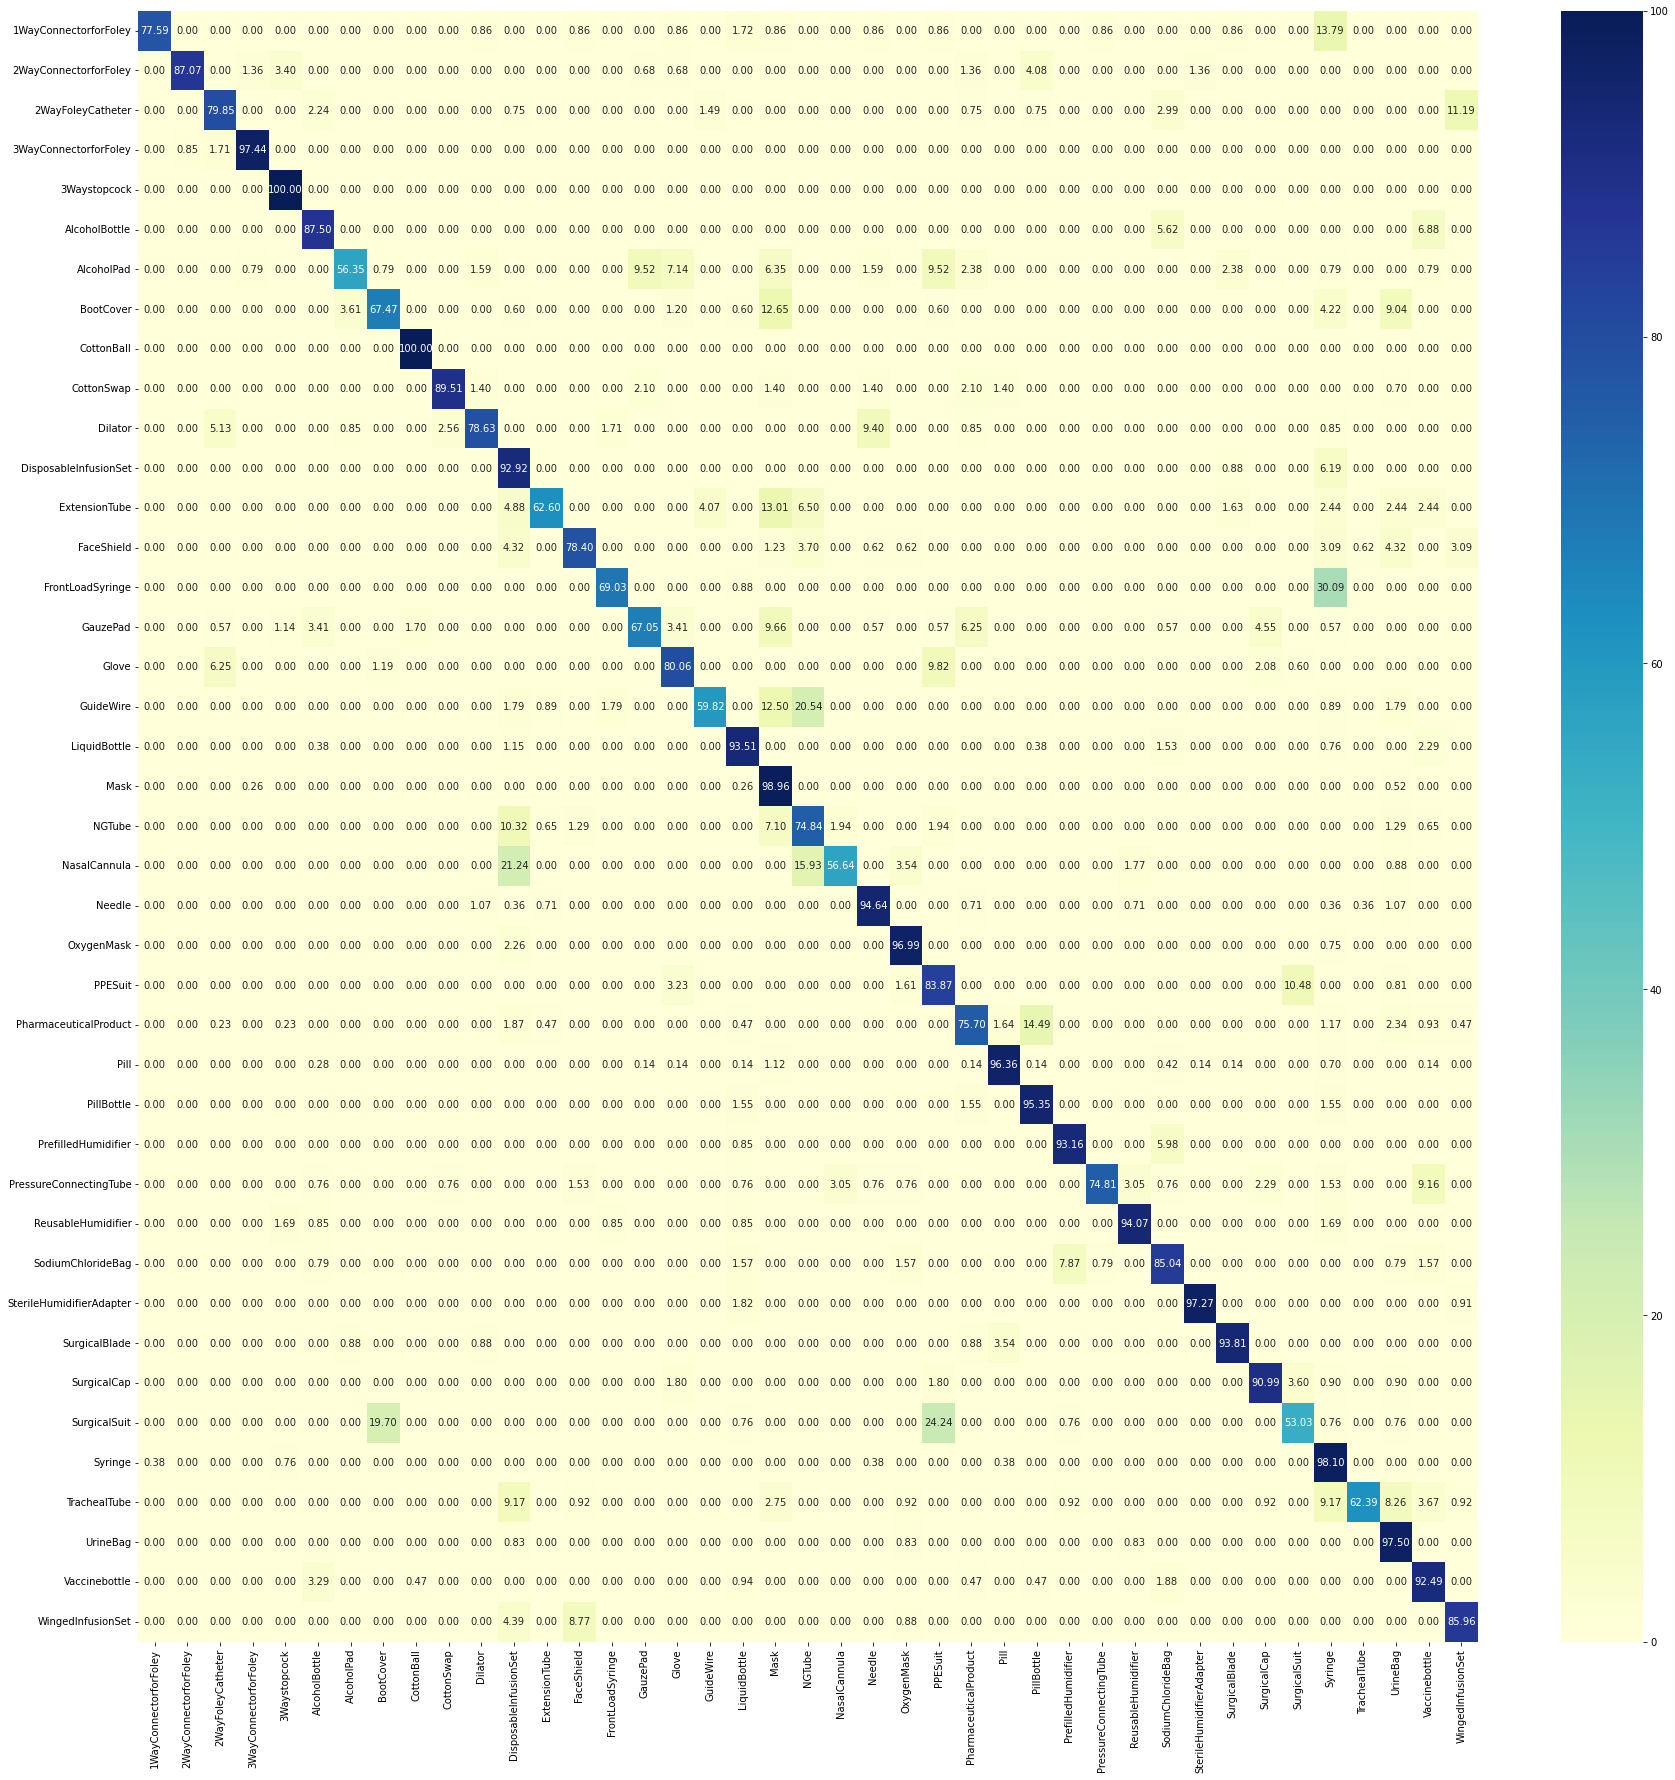

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")